In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge

from batcar import BatCar
from batcar.model_updater import ModelUpdater
from batcar.model_updater.data_selectors import AllSelector, RecentSelector
from batcar.model_updater.wrappers import FrameIO
from batcar.update_trigger import PeriodicTrigger

In [3]:
plt.style.use('makina-notebook')

# Generate Synthetic Data

Text(0.5, 1.0, 'Synthetic Data')

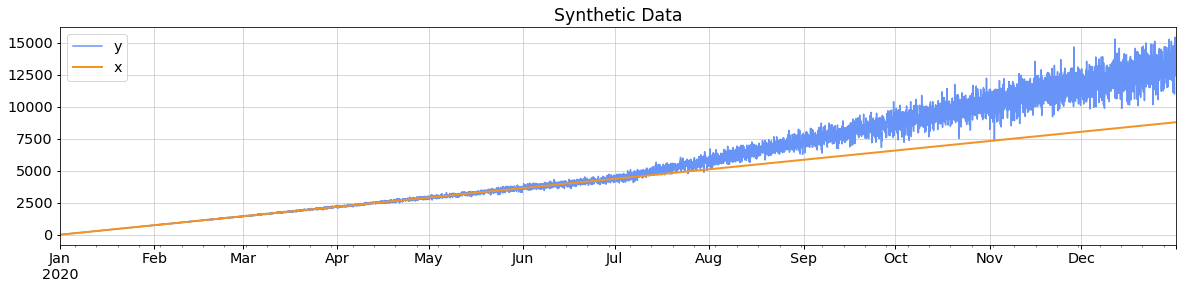

In [4]:
data_times = pd.date_range('2020-01-01 00:00:00', '2021-01-01 00:00:00', freq='1h', closed='left')

n_samples = len(data_times)
n_phase1 = int(n_samples / 2)
n_phase2 = n_samples - n_phase1

x = pd.DataFrame(np.arange(n_samples).reshape(-1, 1), index=data_times, columns=['x'])

y1_clean = np.arange(n_phase1)
y2_clean = np.arange(n_phase2) * 2 + y1_clean[-1]

y_clean = pd.DataFrame(np.concatenate([y1_clean, y2_clean]), index=data_times, columns=['y'])
y_noise = np.random.randn(*y_clean.shape) * (y_clean * 0.03) * (x.to_numpy()*0.0003)

y = y_clean + y_noise

ax = y.plot.line(figsize=(20,4))
ax = x.plot.line(lw=2, ax=ax)
ax.set_title('Synthetic Data')

# Define Model

- Any object implementing `fit` and `predict` can be used.
- If the object has `numpy.array`-based IO, use wrapper `FrameIO` to make it have `pandas.DataFrame-based` IO.


In [5]:
model = FrameIO(Ridge())

# Run BatCar

## Use All Historical Data for Model Update
- In this example, we update the model periodically.

In [6]:
update_interval = '31 days'

data_selector = AllSelector()
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y)

100%|██████████| 88/88 [00:09<00:00,  9.29it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-02-01 00:00:00 |
|         1 | 2020-03-03 00:00:00 |
|         2 | 2020-04-03 00:00:00 |
|         3 | 2020-05-04 00:00:00 |
|         4 | 2020-06-04 00:00:00 |
|         5 | 2020-07-05 00:00:00 |
|         6 | 2020-08-05 00:00:00 |
|         7 | 2020-09-05 00:00:00 |
|         8 | 2020-10-06 00:00:00 |
|         9 | 2020-11-06 00:00:00 |
|        10 | 2020-12-07 00:00:00 |



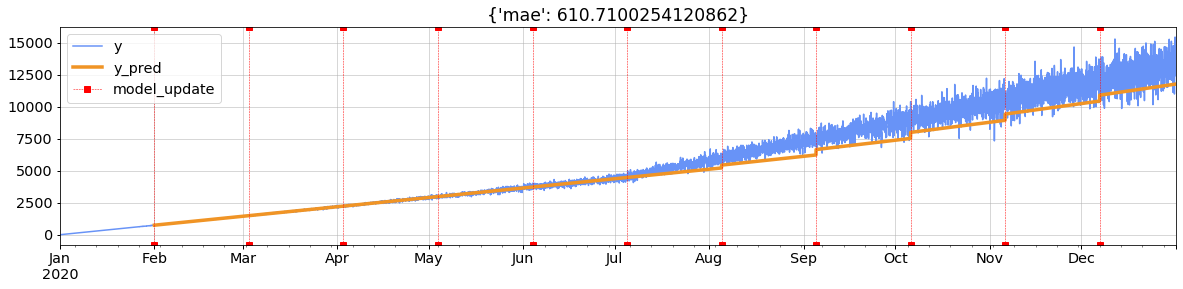

In [7]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=3.5)

for episode_id, episode in batcar.model_table.iterrows():
    if episode_id == batcar.model_table.index[0]:
        kwargs = {'label': 'model_update'}
    else:
        kwargs = {}

    model_build_time = episode['build_time']
    ax.axvline(model_build_time, color='red', ls='--', lw=0.5, marker='s', **kwargs)

ax.set_title(y_eval.mean().to_dict())
ax.legend()

**RESULT: The model adapts to the new pattern due to very old historical data.**

## Use Recent Data for Model Update

In [8]:
update_interval = '31 days'

data_selector = RecentSelector(744)  # 31 days
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y, batch_size=1000)

100%|██████████| 9/9 [00:08<00:00,  1.03it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-02-01 00:00:00 |
|         1 | 2020-03-03 00:00:00 |
|         2 | 2020-04-03 00:00:00 |
|         3 | 2020-05-04 00:00:00 |
|         4 | 2020-06-04 00:00:00 |
|         5 | 2020-07-05 00:00:00 |
|         6 | 2020-08-05 00:00:00 |
|         7 | 2020-09-05 00:00:00 |
|         8 | 2020-10-06 00:00:00 |
|         9 | 2020-11-06 00:00:00 |
|        10 | 2020-12-07 00:00:00 |



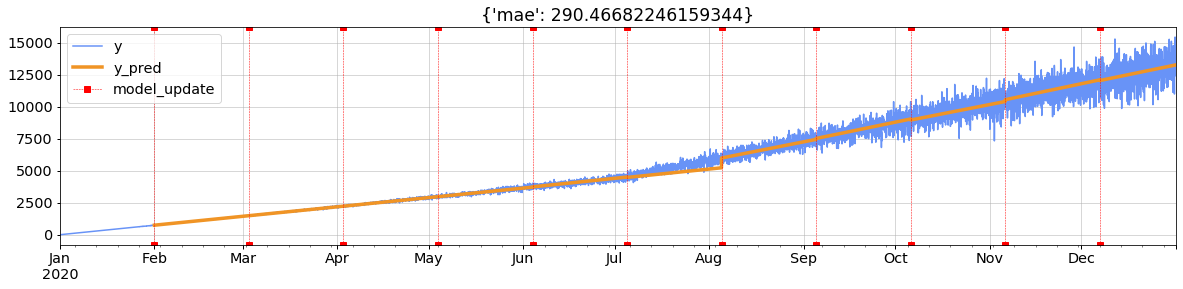

In [9]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=3.5)

for episode_id, episode in batcar.model_table.iterrows():
    if episode_id == batcar.model_table.index[0]:
        kwargs = {'label': 'model_update'}
    else:
        kwargs = {}

    model_build_time = episode['build_time']
    ax.axvline(model_build_time, color='red', ls='--', lw=0.5, marker='s', **kwargs)

ax.set_title(y_eval.mean().to_dict())
ax.legend()

**RESULT: The model quickly adapts to the change.**

## Comparison to No Update
- The same model is trained with the first 31 days.

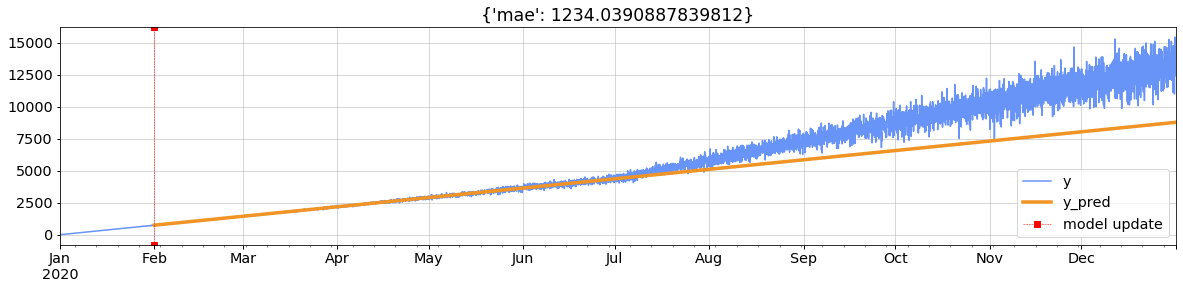

In [10]:
x_train = x.first(pd.Timedelta('31 days'))
y_train = y.loc[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

model = Ridge()

model.fit(x_train, y_train)

y_pred = model.predict(x_test.to_numpy())
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=y_test.columns)

y_eval = BatCar._mean_absolute_error(y_test, y_pred).rename('mae').to_frame()

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=3.5)

ax.axvline(x_test.index[0], color='red', ls='--', lw=0.5, marker='s', label='model update')

ax.set_title(y_eval.mean().to_dict())
ax.legend()

**RESULT: Model performance gets worse over time.**